In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Importation des données :

On cherche à fusionner tout les fichier qu'on a dans le fichier transactions-er en un seul fichier afain d'avoir le maximum de données possible.

In [2]:
folder = '/home/hiba/projet/back-end/transactions-ser'
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(folder, csv_files[0]),delimiter=';')
common_columns = list(df.columns)

In [3]:
for file in csv_files[1:]:
    df_temp = pd.read_csv(os.path.join(folder, file), delimiter=';')
    # Keep only the columns that are present in the first CSV file
    df_temp = df_temp[common_columns]
    #df = df.append(df_temp, ignore_index=False)
    df = pd.concat([df, df_temp], ignore_index=False)
    
df.to_csv('merged.csv')

In [4]:
df = df.replace({'None': None, 'nan': float('nan')})
df

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
0,2022-359835,2022-03-18,1,Vente,115000.0,9001.0,None,IMMEUBLE ATLANTIDE,A651,76800,...,110.0,6.0,None,None,None,None,NaN,1.071577,49.393501,000BS
1,2022-359835,2022-03-18,1,Vente,115000.0,9001.0,None,IMMEUBLE ATLANTIDE,A651,76800,...,NaN,0.0,None,None,None,None,NaN,1.071577,49.393501,000BS
2,2022-359041,2022-01-18,1,Vente,181300.0,4.0,None,ALL DU CLOS MAJORELLE,0517,76800,...,83.0,4.0,S,sols,None,None,97.0,1.068890,49.391763,000BS
3,2022-359041,2022-01-18,1,Vente,181300.0,4.0,None,ALL DU CLOS MAJORELLE,0517,76800,...,NaN,0.0,S,sols,None,None,12.0,1.068805,49.391922,000BS
4,2022-359041,2022-01-18,1,Vente,181300.0,1.0,None,ALL DU CLOS MAJORELLE,0517,76800,...,NaN,0.0,S,sols,None,None,13.0,1.068709,49.392102,000BS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2017-545059,2017-10-25,1,Vente,170000.0,171.0,None,RUE DE PARIS,1840,76800,...,140.0,6.0,S,sols,None,None,727.0,1.106699,49.388487,000BD
90,2017-544418,2017-09-26,1,Vente,174000.0,19.0,None,RUE DE LA REPUBLIQUE,2180,76800,...,57.0,4.0,S,sols,None,None,448.0,1.105192,49.389305,000BD
91,2017-544418,2017-09-26,1,Vente,174000.0,15.0,None,RUE DE LA REPUBLIQUE,2180,76800,...,NaN,NaN,S,sols,None,None,220.0,1.104911,49.389243,000BD
92,2017-543711,2017-08-07,1,Vente,250000.0,145.0,None,RUE DE PARIS,1840,76800,...,153.0,5.0,J,jardins,POTAG,Jardin potager,685.0,1.106324,49.389849,000BD


On a donc un dataFrame de 2972 lignes et 41 colonnes.

### Nettoyage du dataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2972 entries, 0 to 93
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_mutation                   2972 non-null   object 
 1   date_mutation                 2972 non-null   object 
 2   numero_disposition            2972 non-null   int64  
 3   nature_mutation               2972 non-null   object 
 4   valeur_fonciere               2922 non-null   float64
 5   adresse_numero                2487 non-null   float64
 6   adresse_suffixe               117 non-null    object 
 7   adresse_nom_voie              2957 non-null   object 
 8   adresse_code_voie             2957 non-null   object 
 9   code_postal                   2957 non-null   object 
 10  code_commune                  2972 non-null   int64  
 11  nom_commune                   2972 non-null   object 
 12  code_departement              2972 non-null   int64  
 13  ancie

On remarque la présence de beaucoup de valeurs nulls. 
On commence d'abord par supprimer les valeurs nulls des colonnes qui nous interessent le plus : valeur_fonciere et surface_reelle_bati, puis on va remplacer les valeurs manquantes de surface_terrain avec 0

In [6]:
df.dropna(subset = ["valeur_fonciere"], inplace = True)
df.dropna(subset = ["surface_reelle_bati"], inplace = True)
df['surface_terrain'] = df['surface_terrain'].fillna(0)
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1613 entries, 0 to 93
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_mutation                   1613 non-null   object 
 1   date_mutation                 1613 non-null   object 
 2   numero_disposition            1613 non-null   int64  
 3   nature_mutation               1613 non-null   object 
 4   valeur_fonciere               1613 non-null   float64
 5   adresse_numero                1611 non-null   float64
 6   adresse_suffixe               67 non-null     object 
 7   adresse_nom_voie              1613 non-null   object 
 8   adresse_code_voie             1613 non-null   object 
 9   code_postal                   1613 non-null   object 
 10  code_commune                  1613 non-null   int64  
 11  nom_commune                   1613 non-null   object 
 12  code_departement              1613 non-null   int64  
 13  ancie

Vu qu'on s'intéresse qu'aux maisons et aux appratements, on va supprimer les autres valeurs sur la colonne "type_local" et on garde que les maisons et les appartement.

In [7]:
df = df.loc[(df['type_local'] == 'Maison') | (df['type_local'] == 'Appartement')]

Ensuite, on converti la colonne du code_type_local en entier, afin de faciliter les manipulations.

In [8]:
df['code_type_local'] = pd.to_numeric(df['code_type_local'], errors='coerce', downcast='integer')

/tmp/ipykernel_6611/1635837497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['code_type_local'] = pd.to_numeric(df['code_type_local'], errors='coerce', downcast='integer')


On va aussi supprimer les ventes de lots qui sont suppérieur à 1 ainsi que les valeurs qui ne sont pas cohérente : si la surface carrez est suppérieur à la surface bati, c'est une erreur.

In [9]:
df = df.drop(df.loc[df["nombre_lots"]> 1].index)
df.groupby("nombre_lots")[['valeur_fonciere']].count().sort_values("nombre_lots")
df = df.drop(df.loc[df["lot1_surface_carrez"] > df["surface_reelle_bati"]].index)

Le parametre surface du lot carrez est présent quand il s'agit d'un appartement, donc on va utiliser  ce parametre comme surface.
On ajoute une nouvelle colonne "surface", qui prend la surface bati si c'est une maison ou la surface du lot carrez si c'est un appartement

In [10]:
len(df['type_local'] == 'Appartement')

454

In [11]:
len(df['lot1_surface_carrez'])

454

In [12]:
df['surface'] = np.where(df["code_type_local"] == 1, df["surface_reelle_bati"],df["lot1_surface_carrez"])
df.dropna(subset = ["surface"], inplace = True)

On ajoute aussi une colonne pour la date, pour voir si c'est un parametre qui aura un impact

In [13]:
df['date_mutation'] = pd.to_datetime(df['date_mutation'])
df['année'] = df['date_mutation'].dt.year

On supprime les colonnes qui ont plus de 10% de données manquantes

In [14]:
df = df.dropna(thresh=len(df) * 0.10, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 73
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id_mutation                394 non-null    object        
 1   date_mutation              394 non-null    datetime64[ns]
 2   numero_disposition         394 non-null    int64         
 3   nature_mutation            394 non-null    object        
 4   valeur_fonciere            394 non-null    float64       
 5   adresse_numero             394 non-null    float64       
 6   adresse_nom_voie           394 non-null    object        
 7   adresse_code_voie          394 non-null    object        
 8   code_postal                394 non-null    object        
 9   code_commune               394 non-null    int64         
 10  nom_commune                394 non-null    object        
 11  code_departement           394 non-null    int64         
 12  id_parcel

Certains parametre ne sont pas très important, donc on les supprime

In [15]:
df = df.drop(['id_mutation','nature_mutation' , 'adresse_numero','adresse_nom_voie' ,'adresse_code_voie','code_postal', 'nom_commune','code_departement', 'id_parcelle', 'date_mutation','numero_disposition','code_nature_culture','nature_culture','code_commune'], axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 73
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            394 non-null    float64
 1   nombre_lots                394 non-null    int64  
 2   code_type_local            394 non-null    int8   
 3   type_local                 394 non-null    object 
 4   surface_reelle_bati        394 non-null    float64
 5   nombre_pieces_principales  394 non-null    float64
 6   surface_terrain            394 non-null    float64
 7   longitude                  394 non-null    float64
 8   latitude                   394 non-null    float64
 9   section_prefixe            394 non-null    object 
 10  surface                    394 non-null    float64
 11  année                      394 non-null    int64  
dtypes: float64(7), int64(2), int8(1), object(2)
memory usage: 37.3+ KB


Maintenant on dispose d'un dataframe de 11 colonnes, 394 lignes et sans valeurs nulls

In [17]:
df

,valeur_fonciere,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,section_prefixe,surface,année
0,115000.0,1,2,Appartement,110.0,6.0,0.0,1.071577,49.393501,000BS,103.35,2022
16,73000.0,1,2,Appartement,100.0,5.0,0.0,1.071577,49.393501,000BS,94.23,2021
21,375000.0,0,1,Maison,129.0,4.0,1765.0,1.062906,49.390630,000BS,129.00,2021
24,275000.0,0,1,Maison,143.0,6.0,187.0,1.065427,49.390566,000BS,143.00,2021
38,137000.0,0,1,Maison,63.0,4.0,581.0,1.061040,49.392848,000BS,63.00,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
38,175000.0,0,1,Maison,87.0,3.0,861.0,1.106560,49.388892,000BD,87.00,2019
43,93000.0,0,1,Maison,83.0,4.0,133.0,1.105306,49.388171,000BD,83.00,2019
55,90000.0,0,1,Maison,58.0,3.0,58.0,1.105265,49.387870,000BD,58.00,2019
71,91000.0,0,1,Maison,54.0,3.0,43.0,1.105094,49.387773,000BD,54.00,2018


#### détection d'outliers :

In [18]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

s = (df.dtypes == 'int')
int_cols = list(s[s].index)
print("Integer variables:")
print(int_cols)

s = (df.dtypes == 'float')
float_cols = list(s[s].index)
print("Real variables:")
print(float_cols)

Categorical variables:
['type_local', 'section_prefixe']
Integer variables:
['nombre_lots', 'année']
Real variables:
['valeur_fonciere', 'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain', 'longitude', 'latitude', 'surface']


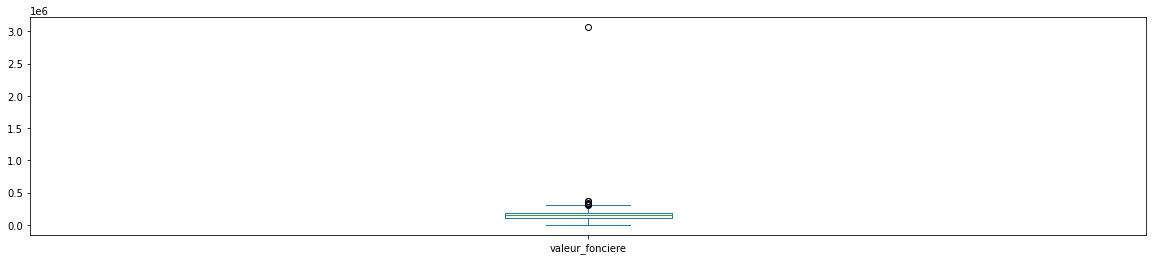

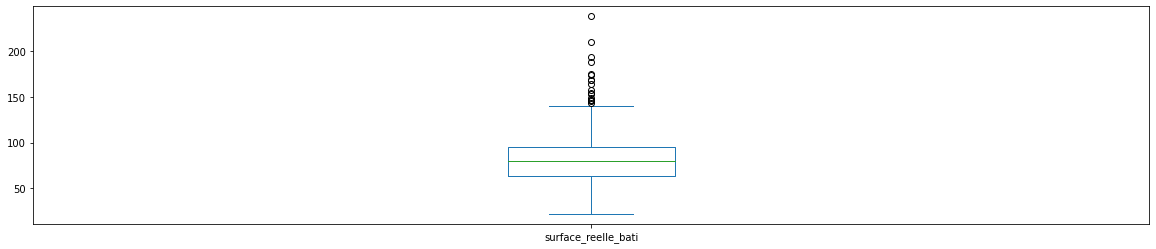

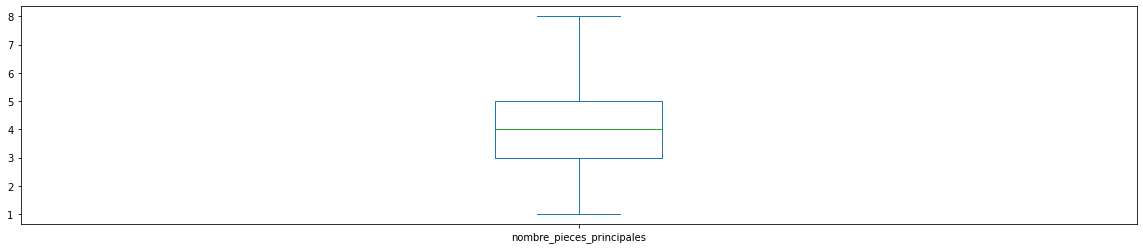

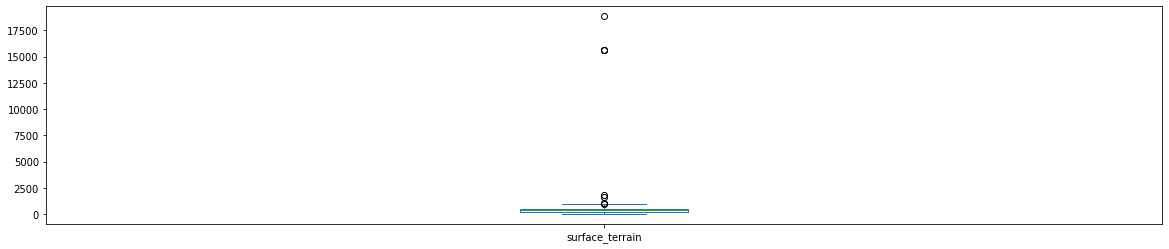

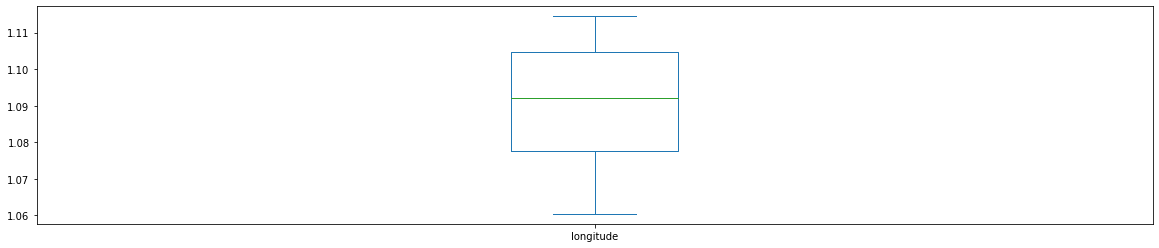

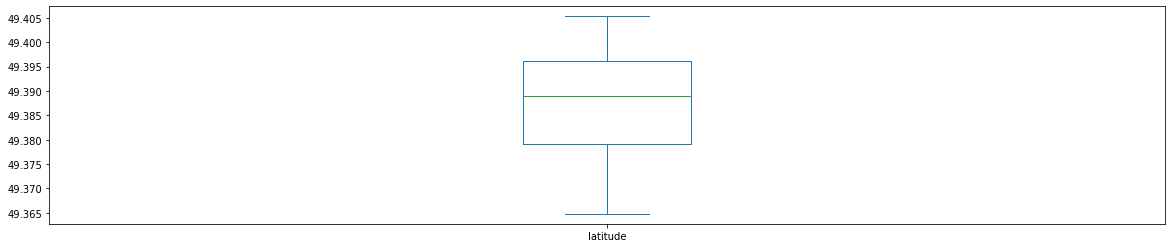

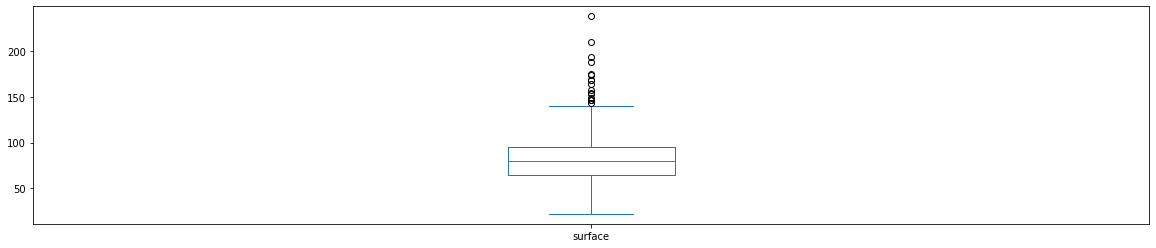

In [128]:
for l in float_cols :
    df[[l]].plot.box(figsize=(20, 4))
    plt.show()

On remarque la présence de beaucoups de valeurs abérantes surtout pour la valeur foncière, la surface reelle, la surface terrain, et la surface. Donc il faut les supprimer

In [19]:
largest_st = df['surface_terrain'].nlargest(len(df[df['surface_terrain'] > 1000]))
df = df.drop(largest_st.index)
largest_vf = df['valeur_fonciere'].nlargest(len(df[df['valeur_fonciere'] > 300000]))
df = df.drop(largest_vf.index)
largest_vf = df['surface'].nlargest(len(df[df['surface'] > 150]))
df = df.drop(largest_vf.index)
largest_vf = df['surface_reelle_bati'].nlargest(len(df[df['surface_reelle_bati'] > 150]))
df = df.drop(largest_vf.index) 

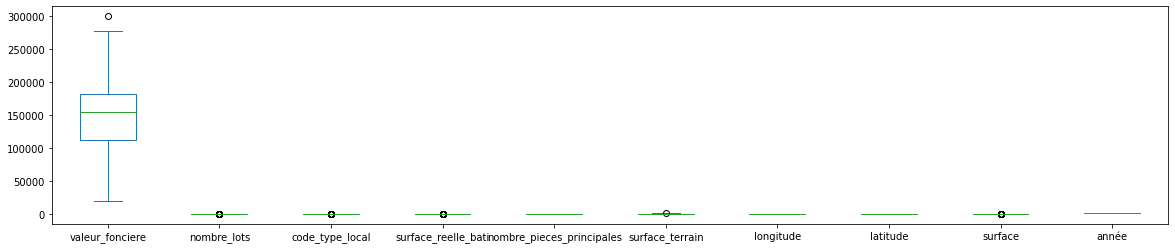

In [20]:
df.plot.box(figsize=(20, 4))

# Show the plot
plt.show()

In [21]:
df

,valeur_fonciere,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,section_prefixe,surface,année
16,73000.0,1,2,Appartement,100.0,5.0,0.0,1.071577,49.393501,000BS,94.23,2021
62,96500.0,1,2,Appartement,64.0,4.0,0.0,1.060400,49.392643,000BS,63.43,2020
71,200000.0,0,1,Maison,86.0,4.0,417.0,1.063211,49.392964,000BS,86.00,2020
110,112000.0,0,1,Maison,63.0,4.0,263.0,1.061100,49.394313,000BS,63.00,2019
117,69000.0,1,2,Appartement,31.0,1.0,0.0,1.071577,49.393501,000BS,30.44,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
33,211550.0,0,1,Maison,130.0,6.0,53.0,1.105048,49.389845,000BD,130.00,2020
43,93000.0,0,1,Maison,83.0,4.0,133.0,1.105306,49.388171,000BD,83.00,2019
55,90000.0,0,1,Maison,58.0,3.0,58.0,1.105265,49.387870,000BD,58.00,2019
71,91000.0,0,1,Maison,54.0,3.0,43.0,1.105094,49.387773,000BD,54.00,2018


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 16 to 73
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            230 non-null    float64
 1   nombre_lots                230 non-null    int64  
 2   code_type_local            230 non-null    int8   
 3   type_local                 230 non-null    object 
 4   surface_reelle_bati        230 non-null    float64
 5   nombre_pieces_principales  230 non-null    float64
 6   surface_terrain            230 non-null    float64
 7   longitude                  230 non-null    float64
 8   latitude                   230 non-null    float64
 9   section_prefixe            230 non-null    object 
 10  surface                    230 non-null    float64
 11  année                      230 non-null    int64  
dtypes: float64(7), int64(2), int8(1), object(2)
memory usage: 21.8+ KB


Après la suppression des valeurs abérantes, on a un dataFrame de 230 lignes.

## Visualisation :

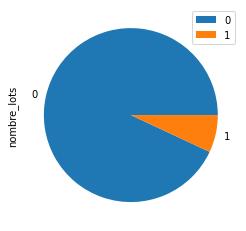

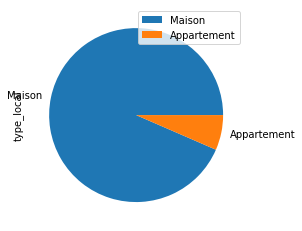

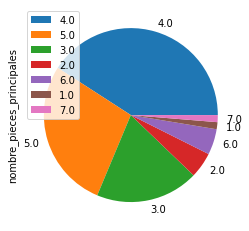

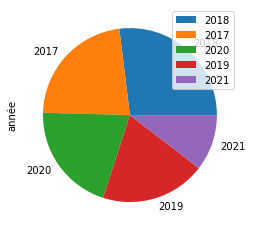

In [23]:
col = ['nombre_lots','type_local','nombre_pieces_principales','année']
for l in col :
    counts = df[[l]].apply(pd.value_counts)
    counts.plot.pie(subplots=True, figsize=(8, 4))
    plt.show()

On remarque que les deux premiers pie charts sont les memes, donc les deux valeurs (nombre de lots et le type de local) représentent la meme chose.

In [135]:
#df.to_csv('new_merged.csv')

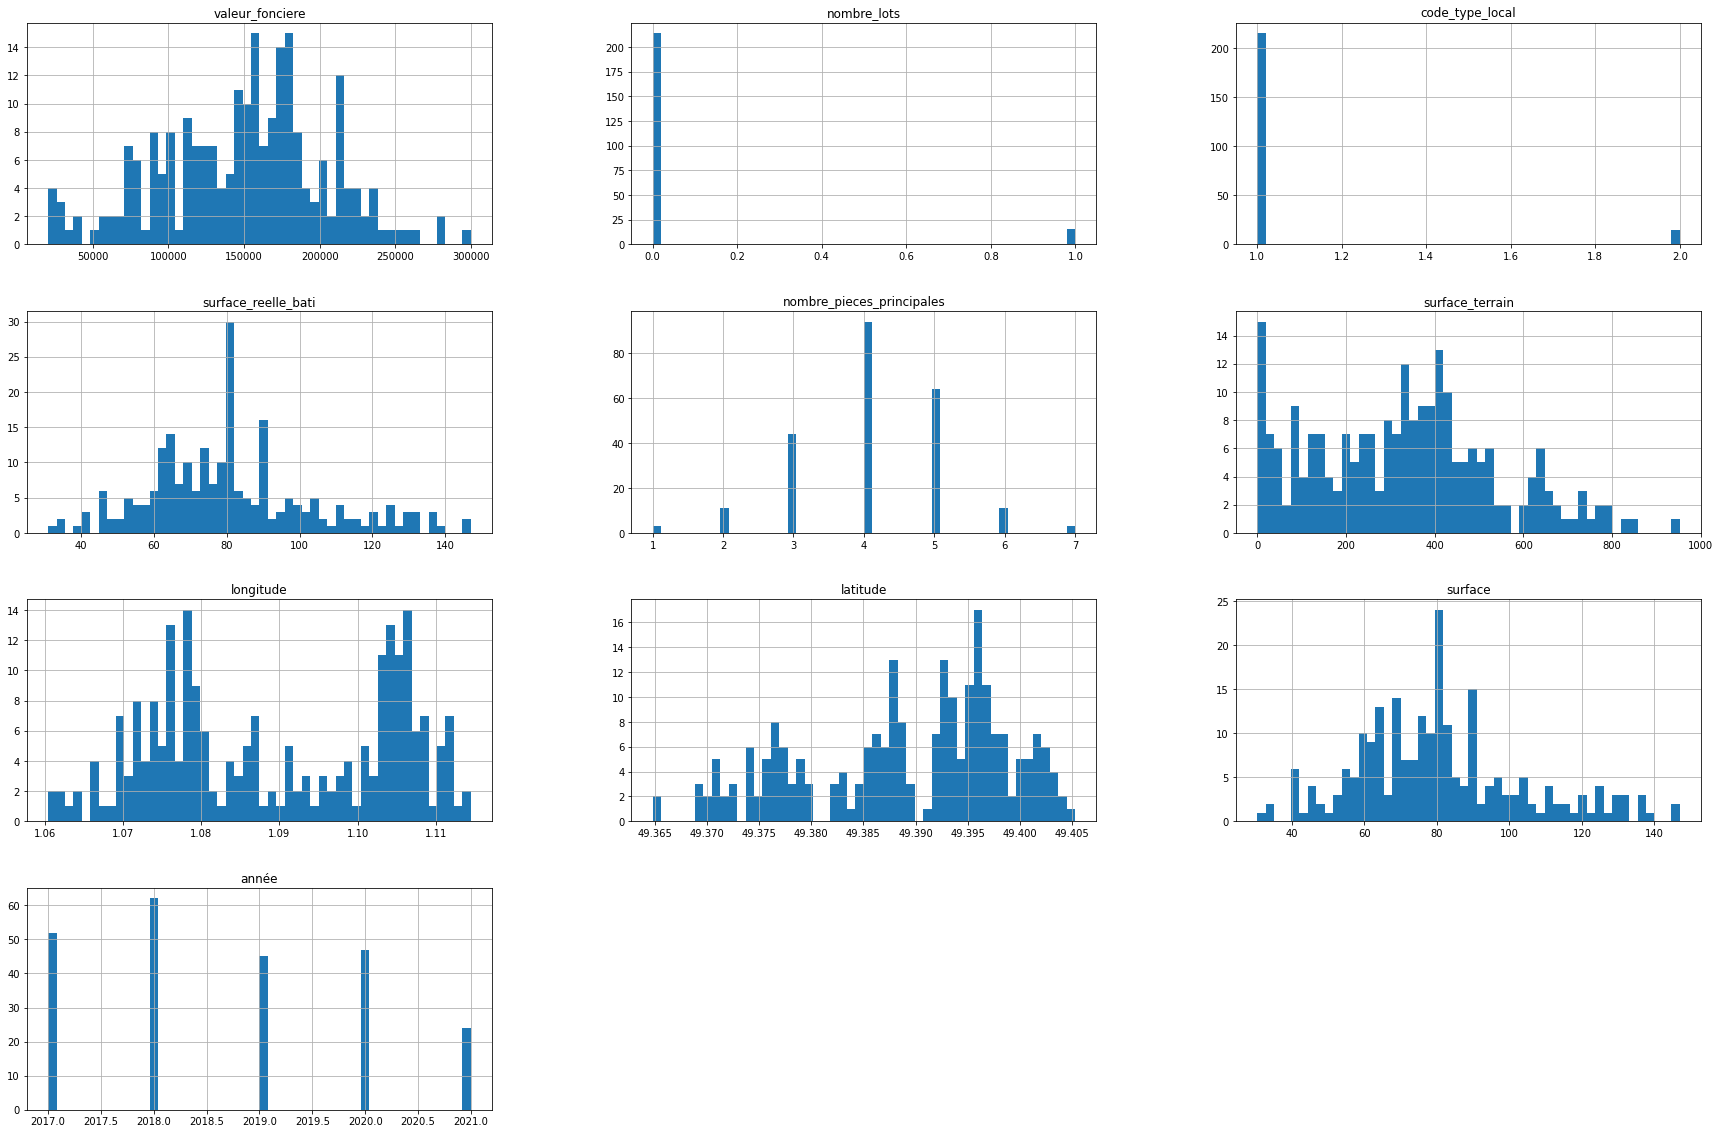

In [24]:
df.hist(bins=50, figsize=(30,20))
plt.show()
     

## Analyse exploratoire des données :
On essaie de trouver les valeurs qui influencent les prix :

<Figure size 144x576 with 0 Axes>

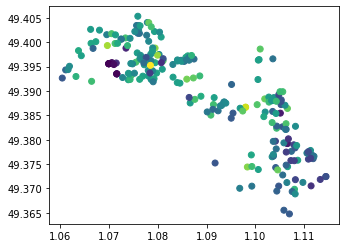

In [25]:
from shapely.geometry import Point

df['Coordinates'] = df.apply(lambda x: Point((x['longitude'], x['latitude'])), axis=1)
plt.figure(figsize=(2, 8))
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')
gdf.plot(column='valeur_fonciere')
df = df.drop(['Coordinates'], axis=1)
plt.show()

On remarque que la localisation géographique n'a pas une très grande influence sur le prix, vu que les couleurs dans le scatter plot ne varient pas selon les coordonnées 

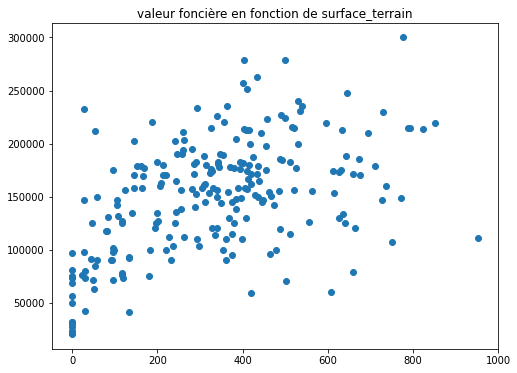

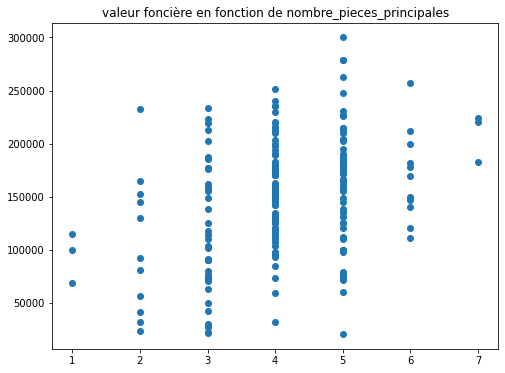

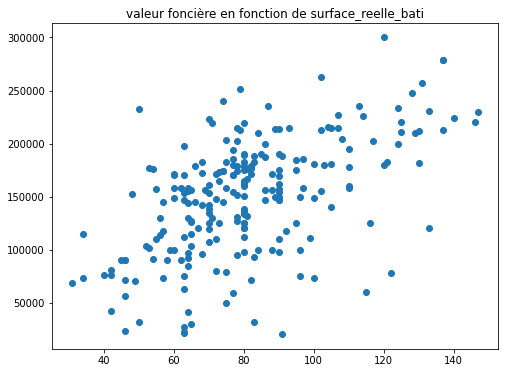

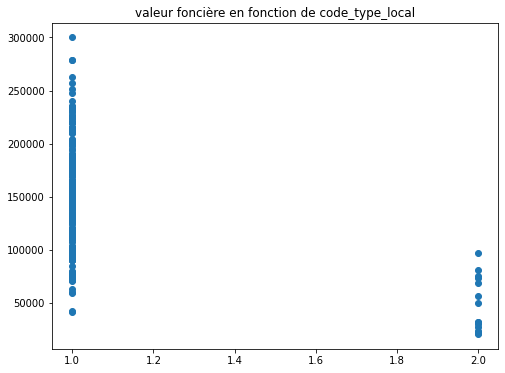

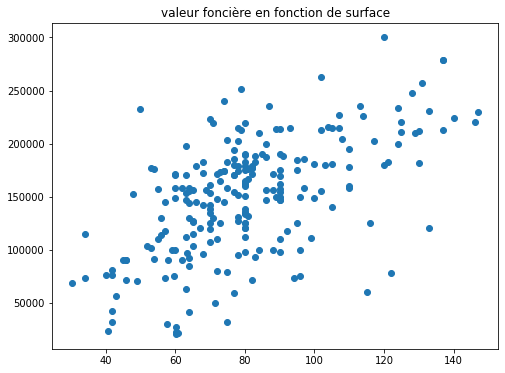

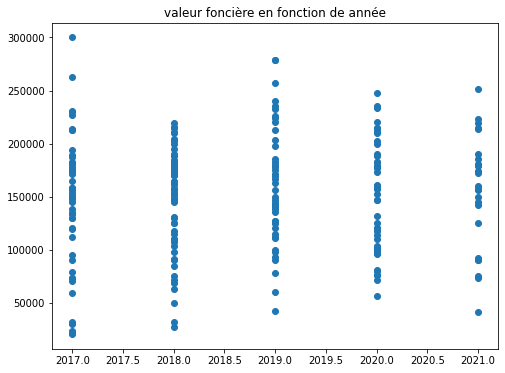

In [27]:
col2 = ['surface_terrain', 'nombre_pieces_principales','surface_reelle_bati','code_type_local','surface','année']
for l in col2 :
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter( df[[l]],df['valeur_fonciere'])
    plt.title('valeur foncière en fonction de ' + l)
    plt.show()

On remarque la présence de coorélations, notament pour la surface terrain, le nombre de pièces, le type du local (les maisons coutent plus que les appartements), la surface et la surface réelle.
Les années ont aussi une coorélations, mais cette répartation est due à au fait que la plus part des ventes étaient en 2017 et 2018 (comme dans le chart pie) et donc on peut dire que les années n'ont pas un grand impact sur les prix

#### La matrice de coorélation :

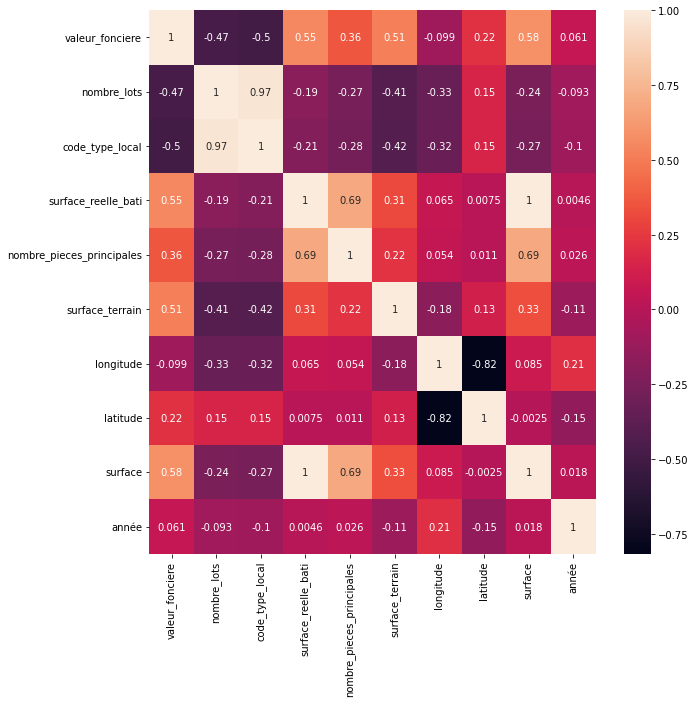

In [28]:
sns.heatmap(df.corr(), annot=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

# supprimer nombre_lots et code_commune

La heatmap permet de mieux voir les corrélations. 
Pour la valeur foncière, elle corrélée positivement avec la surface (Plus la surface est grande plus le prix est elevé)
Elle est aussi corrélé négativement avec le type de local (Les prix des maisons est plus élevé que celui des appartements)
Il existe aussi une corrélation entre la valeur fonciere et la surface du terrain.
Et enfin, on a une corrélation de 36% avec le nombre de pièces

Pour l'apprentissage on va utiliser les paramètres suivant : la surface, le type du local, la surface du terrain et le nombre de pièces.

## Apprentissage :

#### Régression linéaire :

Vu qu'on ne dispose pas d'assez de données (230) pour l'apprentissage, on va génerer un dataFrame basé sur la dataset "df" de 3000 lignes

In [30]:
df_train = df.sample(n=3000, random_state=7,replace=True)
df_train

,valeur_fonciere,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,section_prefixe,surface,année
101,135000.0,0,1,Maison,80.0,5.0,198.0,1.085871,49.396407,000AE,80.0,2017
17,125000.0,0,1,Maison,116.0,5.0,640.0,1.092362,49.385922,000BH,116.0,2021
71,160400.0,0,1,Maison,110.0,4.0,737.0,1.111311,49.377796,000AS,110.0,2020
165,170000.0,0,1,Maison,77.0,4.0,212.0,1.103322,49.388019,000BE,77.0,2018
33,178900.0,0,1,Maison,82.0,4.0,151.0,1.084534,49.391599,000BP,82.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
169,157930.0,0,1,Maison,64.0,3.0,304.0,1.074461,49.395622,000AD,64.0,2017
110,126000.0,0,1,Maison,65.0,4.0,555.0,1.076227,49.401804,000AC,65.0,2019
64,125000.0,0,1,Maison,70.0,3.0,380.0,1.104276,49.378116,000AW,70.0,2018
19,95000.0,0,1,Maison,78.0,4.0,374.0,1.091742,49.375222,000BK,78.0,2017


In [35]:
X = pd.DataFrame(np.c_[df_train["surface"],df_train['code_type_local'],df_train['surface_terrain'],df_train["nombre_pieces_principales"]], columns= ["surface",'code_type_local',"surface_terrain","nombre_pieces_principales"])
y = df_train["valeur_fonciere"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [37]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, y_train)

LinearRegression()

In [38]:
y_pred = lmodellineaire.predict(X_test)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
r2 = round(r2_score(y_test, y_pred),4)

print(f"L'erreur quadratique moyenne est {rmse}€")
print(f"Taux de bonne classification {np.ceil(r2*100)}%")

L'erreur quadratique moyenne est 36195.04€
Taux de bonne classification 58.0%


In [39]:
accuracy = lmodellineaire.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 58%'

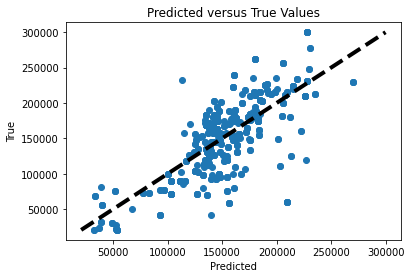

In [40]:
plt.scatter(y_pred, y_test)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Predicted versus True Values')

plt.show()

In [43]:
# Test
surface = 50
nbpieces = 2
terrain = 100
code_local = 2
df_estim = [[surface,code_local,terrain,nbpieces]]
estimation = round(lmodellineaire.predict(df_estim)[0],2)
estimation

/home/hiba/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


56091.69

#### Lasso :

In [44]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.4, normalize=True)
lasso.fit(X_train,y_train)

/home/hiba/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(alpha=0.4, normalize=True)

In [46]:
y_pred_lasso = lasso.predict(X_test)
rmse_lasso = round(np.sqrt(mean_squared_error(y_test, y_pred_lasso)),2)
r2_lasso = round(r2_score(y_test, y_pred_lasso),4)

print(f"L'erreur quadratique moyenne est {rmse_lasso}€")
print(f"Taux de bonne classification {np.ceil(r2_lasso*100)}%")
print('\n')

L'erreur quadratique moyenne est 36190.8€
Taux de bonne classification 58.0%




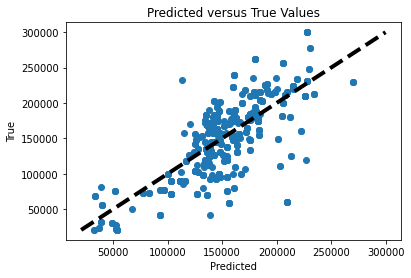

In [47]:
plt.scatter(y_pred_lasso, y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Predicted versus True Values')
plt.show()

In [49]:
# Test
estimation = round(lasso.predict(df_estim)[0],2)
estimation

/home/hiba/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


56109.76

#### Conclusion :

On remarque que les résultats de la régression linéaire et le Lasso sont très proches, donc on va opter pour la régression linéaire.